## Data606 - Capstone Project
```
Group H
Malav Patel, Kent Butler
Prof. Unal Sokaglu
```

This project is about performing time-series analysis on climate data analysis data.



# Research

### References

Some explanations of earth sciences statistics:
https://pjbartlein.github.io/REarthSysSci/ltms-and-anomalies.html

NOAA PSL NCEP-NCAR datasets:  https://psl.noaa.gov/data/gridded/data.ncep.reanalysis.html

NOAA PSL, other recognized data sources directory: https://psl.noaa.gov/data/help/othersources/

Global environmental policy timeline, https://www.boell.de/en/2022/05/28/international-environmental-policy-timeline

OECD convergence of policy, climate,and economy: https://www.oecd.org/

NASA climate time machine: https://climate.nasa.gov/interactives/climate-time-machine

### Factoids

* All of the plastic waste produced in the world in 2019 alone weighs as much as 35,000 Eiffel Towers – 353 million tons  - [*Organization for Economic Cooperation and Development (OECD)*](https://www.boell.de/en/2022/05/28/international-environmental-policy-timeline)



## Application Parameters

Note: algorithm tuning is done with declaration of the model.

In [1]:
import pandas as pd
from datetime import datetime as dt
import datetime

In [2]:
debug = False

DRIVE_PATH = "/content/drive/MyDrive/data606"

# Set the location of this script in GDrive
SCRIPT_PATH = DRIVE_PATH + "/src/"

# Root Path of the data on the cloud drive
DATA_ROOT = DRIVE_PATH + "/data/"

# Model to use
MODEL_NAME = "LSTMv2"

# Journal file
JOURNAL_LOG = SCRIPT_PATH + "cv-results.csv"

# Number of samples to work with - will be split  into train/test
SAMPLE_SIZE = 5000

# Device to run on
run_on_device =  'cpu' # 'cuda'

# Start including data from this date
START_DATE =  pd.to_datetime(dt.fromisoformat('1950-01-01'))
# Stop including data after this date
END_DATE = pd.to_datetime(dt.fromisoformat('2015-12-01'))



**Configure Predictions**

In [3]:
# Label to predict
TARGET_LABEL = 'landSeaAvgTemp'

# Datasets
CO2_DATA = {'filename':"atmospheric-co2.csv",
            'feature_map':{'Carbon Dioxide (ppm)':'co2', 'Seasonally Adjusted CO2 (ppm)':'co2_seas'},
            'date_map':{'Year':'year','Month':'month'}}

SEAICE_DATA = {'filename':"seaice.csv",
               'feature_map':{'     Extent':'ice_extent','    Missing':'ice_missing'},
               'date_map':{' Month':'month','Year':'year',' Day':'day'}}

WEATHER_DATA = {'filename':"finalDatasetWithRain.csv",
                'feature_map':{'air_x':'air_x','air_y':'air_y','uwnd':'uwnd'},
                'date_col':'time'}

VOLCANO_DATA = {'filename':'eruptions-conditioned.csv',
                'feature_map':{'vei':'volcanic_idx'},
                'date_map':{'start_year':'year','start_month':'month'}}

FOREST_DATA = {'filename':'WorldForestCover.csv',
               'feature_map':{'PctCover':'pct_forest_cover'},
               'date_map':{'Year':'year'}}

SUNSPOT_DATA = {'filename':'sunspotnumber.csv',
               'feature_map':{'suns_spot_number':'sunspot_num'},
               'date_map':{'year':'year'}}

#GHG_DATA = {'filename':'greenhouse_gas_inventory_data.csv',
#            'feature_map':{''},
#            'date_map':{'Year':'year'}}

ALL_DATASETS = [CO2_DATA, SEAICE_DATA, WEATHER_DATA, VOLCANO_DATA, FOREST_DATA, SUNSPOT_DATA]

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd $SCRIPT_PATH

/content/drive/MyDrive/data606/src


In [6]:
# Load util class
%run -i "./ProjectUtil.ipynb"

In [7]:
# Load util class
#%run -i "./WindowGenerator.ipynb"

# Data Load

In [8]:
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.rcParams["figure.figsize"] = (10,6)
import warnings

In [9]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
%matplotlib inline

---

**Initial Data Load**

---

In [10]:
# Load util class
%run -i "./Dataset_Merger.ipynb"

In [11]:
# Declare a merger compatible with our source data and our target dataset we want to merge into
merger = Dataset_Merger(data_path=DATA_ROOT, start_date=START_DATE, end_date=END_DATE, debug=True)

------------------------------------------
 ###  ============================================================
  Loading data/content/drive/MyDrive/data606/data/GlobalTemperatures.csv

 ### Defaulting df_aggr to reference df
------------------------------------------
 ### Renaming columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3192 non-null   object 
 1   landAvgTemp                                3180 non-null   float64
 2   LandAverageTemperatureUncertainty          3180 non-null   float64
 3   landMaxTemp                                1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   landMinTemp                                1992 non-null   float64
 6   LandMinTemperatureUncert

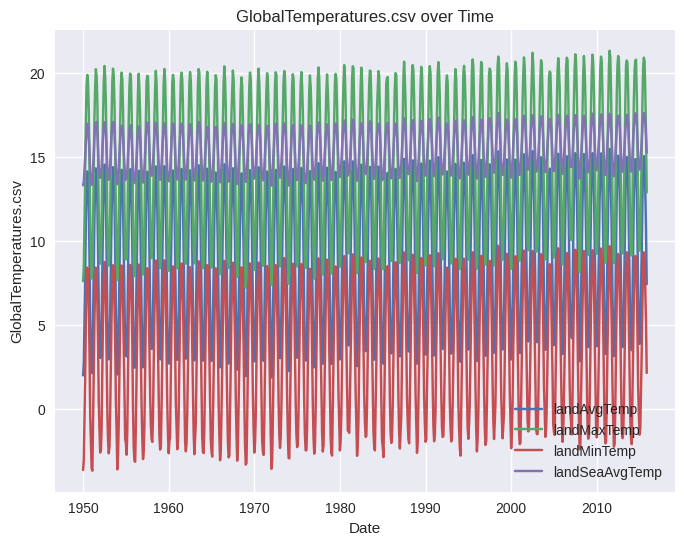

In [12]:
# Start by merging initial dataset
df_merge = merger.merge_dataset('GlobalTemperatures.csv',
                            {'LandAverageTemperature':'landAvgTemp',	'LandMaxTemperature':'landMaxTemp',	'LandMinTemperature':'landMinTemp',	'LandAndOceanAverageTemperature':'landSeaAvgTemp'},
                                date_col='dt')


In [13]:
print(assess_na(df_merge))

  _date_  day year month landAvgTemp landMaxTemp landMinTemp landSeaAvgTemp
0    0.0  0.0  0.0   0.0         0.0         0.0         0.0            0.0


---

**Merge Additional Data**

---

------------------------------------------
 ###  ============================================================
  Loading data/content/drive/MyDrive/data606/data/atmospheric-co2.csv

------------------------------------------
 ### Renaming columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 7 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   year                               720 non-null    int64  
 1   month                              720 non-null    int64  
 2   Decimal Date                       720 non-null    float64
 3   co2                                703 non-null    float64
 4   co2_seas                           703 non-null    float64
 5   Carbon Dioxide Fit (ppm)           707 non-null    float64
 6   Seasonally Adjusted CO2 Fit (ppm)  707 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 39.5 KB
-----------------------

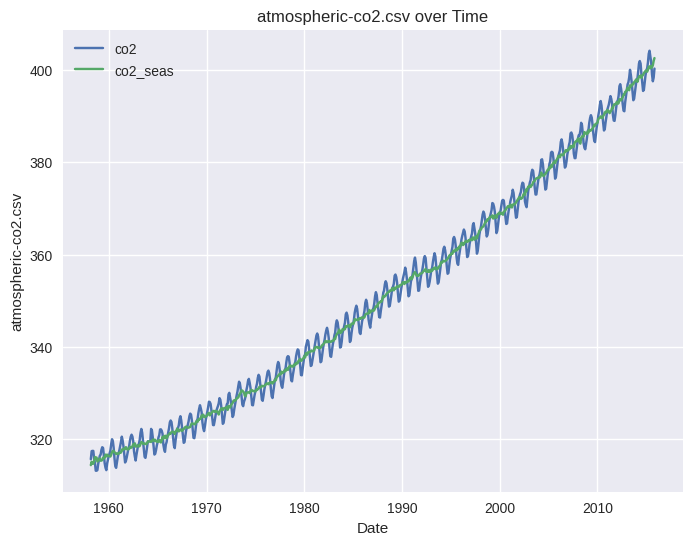

  _date_  day year month landAvgTemp landMaxTemp landMinTemp landSeaAvgTemp  \
0    0.0  0.0  0.0   0.0         0.0         0.0         0.0            0.0   

        co2  co2_seas  
0  0.123894  0.123894  
------------------------------------------
 ###  ============================================================
  Loading data/content/drive/MyDrive/data606/data/seaice.csv

------------------------------------------
 ### Renaming columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26354 entries, 0 to 26353
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          26354 non-null  int64  
 1   month         26354 non-null  int64  
 2   day           26354 non-null  int64  
 3   ice_extent    26354 non-null  float64
 4   ice_missing   26354 non-null  float64
 5    Source Data  26354 non-null  object 
 6   hemisphere    26354 non-null  object 
dtypes: float64(2), int64(3), object(2)
memory usage: 1.4+ MB

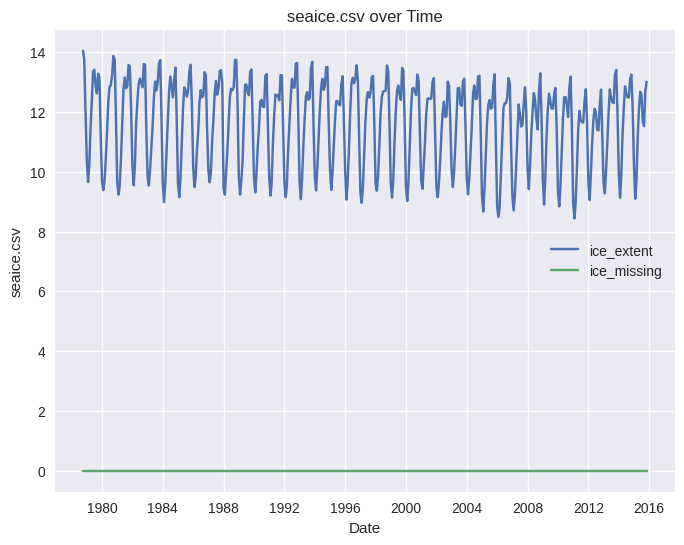

  _date_  day year month landAvgTemp landMaxTemp landMinTemp landSeaAvgTemp  \
0    0.0  0.0  0.0   0.0         0.0         0.0         0.0            0.0   

        co2  co2_seas ice_extent ice_missing  
0  0.123894  0.123894   0.436157    0.436157  
------------------------------------------
 ###  ============================================================
  Loading data/content/drive/MyDrive/data606/data/finalDatasetWithRain.csv

------------------------------------------
 ### Renaming columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622392 entries, 0 to 622391
Data columns (total 71 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   lat       622392 non-null  float64
 1   lon       622392 non-null  float64
 2   time      622392 non-null  object 
 3   air_x     622392 non-null  float64
 4   air_y     311196 non-null  float64
 5   air       0 non-null       float64
 6   lftx4     311196 non-null  float64
 7   cfnlf     622392 non

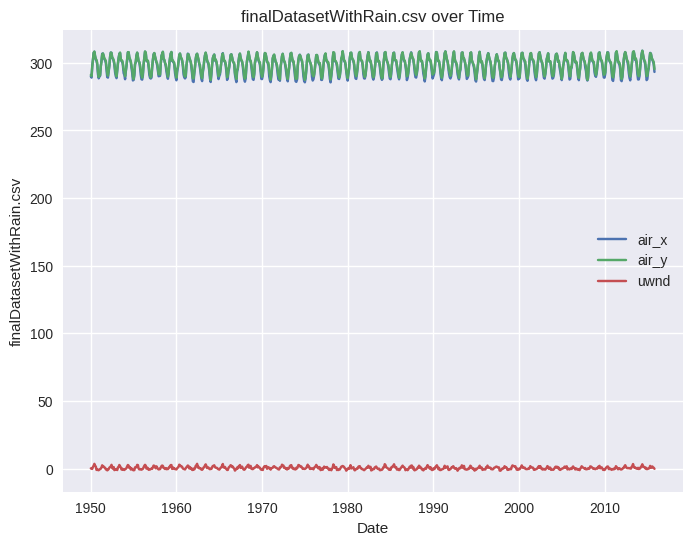

  _date_  day year month landAvgTemp landMaxTemp landMinTemp landSeaAvgTemp  \
0    0.0  0.0  0.0   0.0         0.0         0.0         0.0            0.0   

        co2  co2_seas ice_extent ice_missing air_x air_y uwnd  
0  0.123894  0.123894   0.436157    0.436157   0.0   0.0  0.0  
------------------------------------------
 ###  ============================================================
  Loading data/content/drive/MyDrive/data606/data/eruptions-conditioned.csv

------------------------------------------
 ### Renaming columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6221 entries, 0 to 6220
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              6221 non-null   int64  
 1   volcano_number          6221 non-null   int64  
 2   volcano_name            6221 non-null   object 
 3   eruption_number         6221 non-null   int64  
 4   eruption_category       6221 no

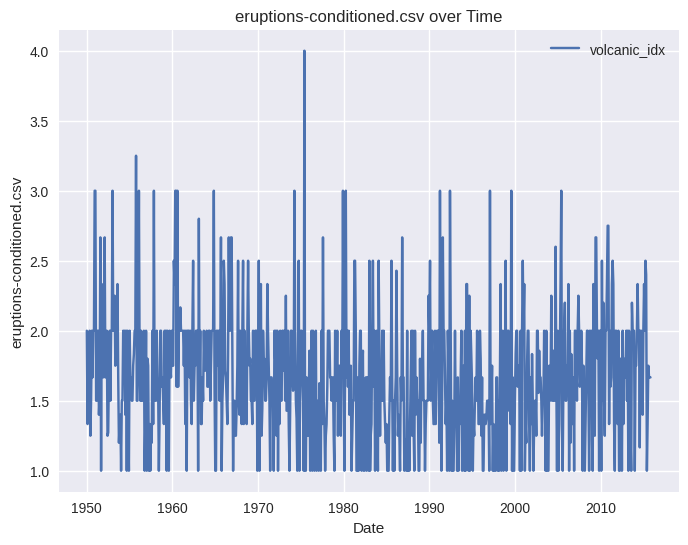

  _date_  day year month landAvgTemp landMaxTemp landMinTemp landSeaAvgTemp  \
0    0.0  0.0  0.0   0.0         0.0         0.0         0.0            0.0   

        co2  co2_seas ice_extent ice_missing air_x air_y uwnd volcanic_idx  
0  0.123894  0.123894   0.436157    0.436157   0.0   0.0  0.0          0.0  
------------------------------------------
 ###  ============================================================
  Loading data/content/drive/MyDrive/data606/data/WorldForestCover.csv

------------------------------------------
 ### Renaming columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860 entries, 0 to 859
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              860 non-null    int64  
 1   Country           860 non-null    object 
 2   TotalArea         860 non-null    float64
 3   CoverArea         860 non-null    int64  
 4   pct_forest_cover  860 non-null    float64
dtypes:

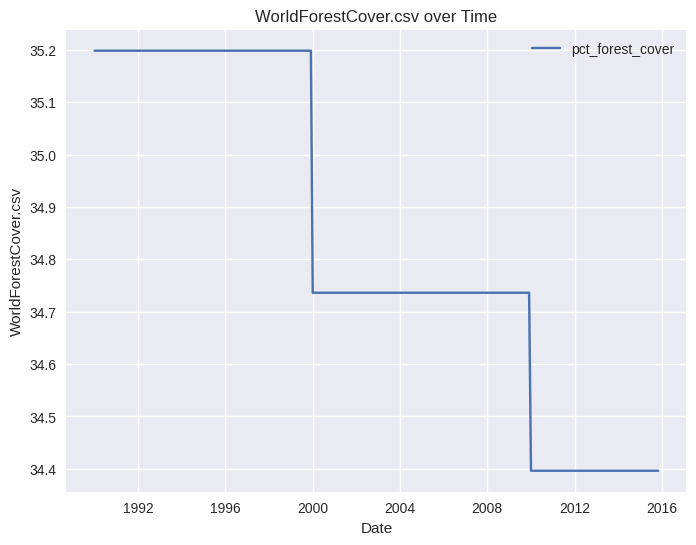

  _date_  day year month landAvgTemp landMaxTemp landMinTemp landSeaAvgTemp  \
0    0.0  0.0  0.0   0.0         0.0         0.0         0.0            0.0   

        co2  co2_seas ice_extent ice_missing air_x air_y uwnd volcanic_idx  \
0  0.123894  0.123894   0.436157    0.436157   0.0   0.0  0.0          0.0   

  pct_forest_cover  
0         0.606827  
------------------------------------------
 ###  ============================================================
  Loading data/content/drive/MyDrive/data606/data/sunspotnumber.csv

------------------------------------------
 ### Renaming columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         315 non-null    int64  
 1   sunspot_num  315 non-null    float64
 2   Unnamed: 2   0 non-null      float64
 3   Unnamed: 3   0 non-null      float64
 4   Unnamed: 4   0 non-null      float64

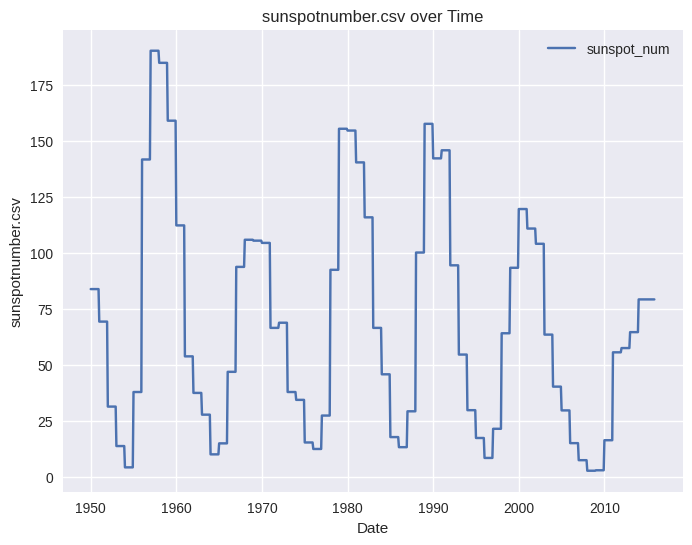

  _date_  day year month landAvgTemp landMaxTemp landMinTemp landSeaAvgTemp  \
0    0.0  0.0  0.0   0.0         0.0         0.0         0.0            0.0   

        co2  co2_seas ice_extent ice_missing air_x air_y uwnd volcanic_idx  \
0  0.123894  0.123894   0.436157    0.436157   0.0   0.0  0.0          0.0   

  pct_forest_cover sunspot_num  
0         0.606827         0.0  


In [14]:
for dataset in ALL_DATASETS:
  if ('date_map' in dataset):
    df_merge = merger.merge_dataset(dataset['filename'],
                                    feature_map=dataset['feature_map'],
                                    df_aggr=df_merge,
                                    date_map=dataset['date_map'])
  else:
    df_merge = merger.merge_dataset(dataset['filename'],
                                feature_map=dataset['feature_map'],
                                df_aggr=df_merge,
                                date_col=dataset['date_col'])
  print(assess_na(df_merge))

In [15]:
df_merge

,_date_,day,year,month,landAvgTemp,landMaxTemp,landMinTemp,landSeaAvgTemp,co2,co2_seas,ice_extent,ice_missing,air_x,air_y,uwnd,volcanic_idx,pct_forest_cover,sunspot_num
0,1950-01-01,1.0,1950,1,2.008,7.611,-3.622,13.311,NaN,NaN,NaN,NaN,289.936261,290.994544,0.220916,2.000000,NaN,83.9
1,1950-02-01,1.0,1950,2,2.721,8.475,-3.013,13.554,NaN,NaN,NaN,NaN,289.002692,290.035596,-0.067231,1.333333,NaN,83.9
2,1950-03-01,1.0,1950,3,5.247,11.173,-0.693,14.296,NaN,NaN,NaN,NaN,297.095738,296.936238,-0.181692,1.666667,NaN,83.9
3,1950-04-01,1.0,1950,4,8.123,14.157,2.043,15.093,NaN,NaN,NaN,NaN,302.377345,302.449196,1.313697,1.666667,NaN,83.9
4,1950-05-01,1.0,1950,5,11.297,17.252,5.421,16.033,NaN,NaN,NaN,NaN,307.291194,307.264517,2.175056,2.000000,NaN,83.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2015-07-01,1.0,2015,7,15.051,20.904,9.326,17.611,401.60,400.76,12.576548,0.0,303.987030,304.114913,0.649732,1.333333,34.396326,79.3
787,2015-08-01,1.0,2015,8,14.755,20.699,9.005,17.589,399.00,400.51,11.674048,0.0,302.203831,302.469150,1.620498,1.750000,34.396326,79.3
788,2015-09-01,1.0,2015,9,12.999,18.845,7.199,17.049,397.50,400.98,11.529883,0.0,300.948820,301.557981,1.038612,1.666667,34.396326,79.3
789,2015-10-01,1.0,2015,10,10.801,16.450,5.232,16.290,398.28,401.90,12.687742,0.0,298.714987,300.453620,0.634611,1.666667,34.396326,79.3


---

**Merge seaice**

---

---

**Merge Weather Data**

---

---

**Assess Merged Data**

---

In [16]:
# It's time to set date as index and remove from dataset
df_merge.set_index('_date_', inplace=True, drop=True)

In [17]:
df_merge

,day,year,month,landAvgTemp,landMaxTemp,landMinTemp,landSeaAvgTemp,co2,co2_seas,ice_extent,ice_missing,air_x,air_y,uwnd,volcanic_idx,pct_forest_cover,sunspot_num
_date_,,,,,,,,,,,,,,,,,
1950-01-01,1.0,1950,1,2.008,7.611,-3.622,13.311,NaN,NaN,NaN,NaN,289.936261,290.994544,0.220916,2.000000,NaN,83.9
1950-02-01,1.0,1950,2,2.721,8.475,-3.013,13.554,NaN,NaN,NaN,NaN,289.002692,290.035596,-0.067231,1.333333,NaN,83.9
1950-03-01,1.0,1950,3,5.247,11.173,-0.693,14.296,NaN,NaN,NaN,NaN,297.095738,296.936238,-0.181692,1.666667,NaN,83.9
1950-04-01,1.0,1950,4,8.123,14.157,2.043,15.093,NaN,NaN,NaN,NaN,302.377345,302.449196,1.313697,1.666667,NaN,83.9
1950-05-01,1.0,1950,5,11.297,17.252,5.421,16.033,NaN,NaN,NaN,NaN,307.291194,307.264517,2.175056,2.000000,NaN,83.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-01,1.0,2015,7,15.051,20.904,9.326,17.611,401.60,400.76,12.576548,0.0,303.987030,304.114913,0.649732,1.333333,34.396326,79.3
2015-08-01,1.0,2015,8,14.755,20.699,9.005,17.589,399.00,400.51,11.674048,0.0,302.203831,302.469150,1.620498,1.750000,34.396326,79.3
2015-09-01,1.0,2015,9,12.999,18.845,7.199,17.049,397.50,400.98,11.529883,0.0,300.948820,301.557981,1.038612,1.666667,34.396326,79.3


---

**Assess correlations**

---

In [18]:
# Assess correlations between all data columns
df_corr = df_merge.corr()

In [19]:
# Identify the columns which have medium to strong correlation with target
df_corr_cols = df_corr[df_corr[TARGET_LABEL] > 0.5]

In [20]:
# Drop the target from the correlation results in case we want to use this reduced set
#    in place of the full set
df_corr_cols = df_corr_cols.drop(columns=[])

In [21]:
# Extract just the column names
corr_cols = df_corr_cols.index.values

In [22]:
if debug:
  print(corr_cols)

Text(0.5, 1.0, 'Heatmap of correlation among variables')

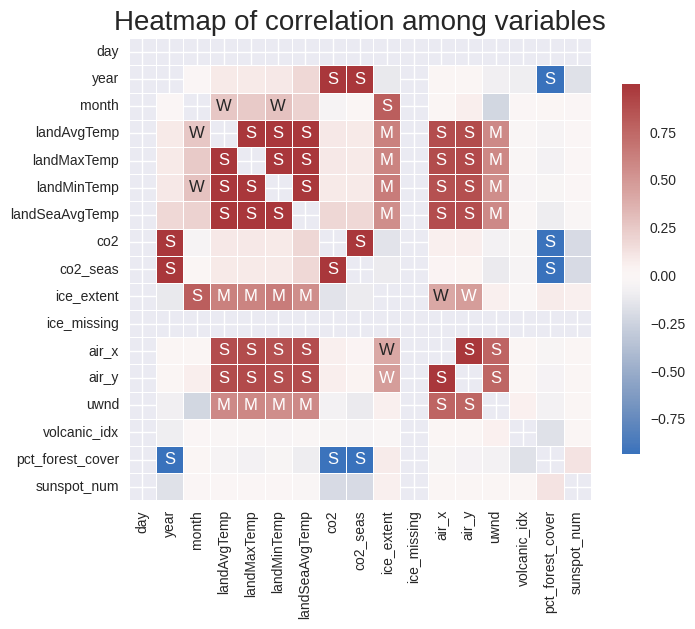

In [23]:
# Add labels
labels = np.where(np.abs(df_corr) > 0.75, 'S',
                  np.where(np.abs(df_corr) > 0.5, 'M',
                           np.where(np.abs(df_corr) > 0.25, 'W', '')))
# Plot the matrix
plt.figure(figsize=(8,6))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt = '', linewidths = .5,
            cmap='vlag', cbar_kws={'shrink':0.8});
plt.title('Heatmap of correlation among variables', fontsize=20)

**Assess Periodicity**

```
# removed kendalltau analysis
# Replace with fft graph of major freqs?
```


**Resampling**

Time intervals are already at monthly target.

In [24]:
df_merge.shape

(791, 17)

Ready for time series modeling.

---

**Prepare for Modeling**

---

**Basic model params**

In [25]:
# History lookback in network
INPUT_WINDOW = 60
# How far forward to predict
LABEL_WINDOW = 1
# Ratio of test data to train data - used for split
TEST_RATIO = 0.2
# 0..1 percent of data to use as validation
VALIDATION_RATIO = 0.1
# Num epochs
NUM_EPOCHS = 300

**Extract label data**

---

**Data pre-processing**

---

**Extract labels**

Time series creates a supervised learning problem out of moving data.

**Dataset stats**

In [26]:
NUM_FEATURES = len(df_merge.columns)

# Capture stats on number of non-metadata columns - so, exclude some stuff
#NET_NUM_FEATURES = len(set(df_merge.columns) - set(['year','month','day']))

In [27]:
# Keep rows aside for post validation?
TOTAL_ROWS = df_merge.shape[0]
NUM_VALIDATION = math.floor(TOTAL_ROWS * VALIDATION_RATIO)
WORKING_ROWS = TOTAL_ROWS - NUM_VALIDATION

In [28]:
# Split non-validation rows into train/test
NUM_TEST = math.floor(WORKING_ROWS * TEST_RATIO)
NUM_TRAIN = WORKING_ROWS - NUM_TEST

In [29]:
print(f'Num features: {NUM_FEATURES}')
print(f'Total rows: {TOTAL_ROWS}')
print(f'Validation rows: {NUM_VALIDATION}')
print(f'Train rows: {NUM_TRAIN}')
print(f'Test rows: {NUM_TEST}')

Num features: 17
Total rows: 791
Validation rows: 79
Train rows: 570
Test rows: 142


**Split into Train/Test**

In [30]:
df_train = df_merge.iloc[:NUM_TRAIN, :]
df_test = df_merge.iloc[NUM_TRAIN:NUM_TRAIN+NUM_VALIDATION, :]
df_val = df_merge.iloc[NUM_TRAIN+NUM_VALIDATION:, :]

In [31]:
y_train = df_train[TARGET_LABEL]
y_test = df_test[TARGET_LABEL]
y_val = df_val[TARGET_LABEL]

In [32]:
if debug:
  print(f'df_train: {df_train.shape}')
  print(f'y_train: {y_train.shape}')
  print(f'df_test: {df_test.shape}')
  print(f'y_test: {y_test.shape}')
  print(f'df_val: {df_val.shape}')
  print(f'y_val: {y_val.shape}')

**Scale data**

Doing this **after** the split means that training data doesn't get unfair advantage of looking ahead into the 'future' during test & validation.

In [33]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [34]:
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer,  QuantileTransformer, Normalizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [35]:
# Create small pipeline for numerical features
numeric_pipeline = Pipeline(steps = [('impute', SimpleImputer(strategy='mean')),
                                    ('scale', MinMaxScaler())])

In [36]:
# get names of numerical features
con_lst = df_train.select_dtypes(include='number').columns.to_list()

In [37]:
# Transformer for applying Pipelines
column_transformer = ColumnTransformer(transformers = [('number', numeric_pipeline, con_lst)])

In [38]:
# Transform data features
X_train_tx = column_transformer.fit_transform(df_train)
X_test_tx = column_transformer.transform(df_test)
X_val_tx = column_transformer.transform(df_val)
X_train_tx.shape, X_test_tx.shape, X_val_tx.shape

((570, 17), (79, 17), (142, 17))

In [39]:
# Transform labels
label_scaler = MinMaxScaler()
y_train_tx = label_scaler.fit_transform(y_train.values.reshape(-1, 1))

In [40]:
if debug:
  print(f'X_train:scaled: {X_train_tx[0]}')
  print(f'y_train:scaled: {y_train_tx[0]}')

**Extract X and y**

Normally we would do this by explicitly extracting data from our df.

However for a time series, we're going to create many small supervised learning sets, so a set of X and y pairs.

We should end up with data in a shape ready for batched network input:

`batches X time_steps X features`



In [41]:
#windowing = TfWindowGenerator(input_width=INPUT_WINDOW,
#                              label_width=LABEL_WINDOW,
#                              shift=LABEL_WINDOW,
#                              label_columns=[TARGET_LABEL])

In [42]:
# Pull X and y out of Training data
#X, y = windowing.generate(df_train)

In [43]:
# testing more direct extraction
#X = np.asarray(df.drop(columns=[TARGET_LABEL]))
#X = np.asarray(df)

In [44]:
if debug:
  print(f'X_train_tx: {X_train_tx.shape}')
  print(f'y_train_tx: {y_train_tx.shape}')

---

**Modeling**

---

In [45]:
# These are the features we are going to be modeling
COLS = list(df_merge.columns)

**Slice into Batches**

In [46]:
# TensorFlow has a util for creating its batching DataSet from this type of data
#tf_dataset = tf.keras.utils.timeseries_dataset_from_array(
#    data=X,
#    targets=None,
#    sequence_length=INPUT_WINDOW,
#    sequence_stride=1,
#    shuffle=True,
#    batch_size=32,)

In [47]:
#ds = windowing.make_dataset(X, y)

In [48]:
ds = tf.keras.utils.timeseries_dataset_from_array(
    data=X_train_tx,
    targets=y_train_tx,
    sequence_length=INPUT_WINDOW)

In [49]:
ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 17), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

**Prep GPU**

In [50]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


**Build model**

In [51]:
# Load model class
%run -i "./Model_LSTMv2.ipynb"

In [52]:
model = ModelLSTMv2(window_size=INPUT_WINDOW, num_epochs=NUM_EPOCHS, debug=True)

### Building ModelLSTMv2::


**Train model**

In [53]:
#model.train(X, y, NUM_FEATURES)
model_history = model.train(dataset=ds, num_features=NUM_FEATURES)

Epoch 1/300
4/4 [==============================] - 23s 145ms/step - loss: 0.3546
Epoch 2/300
4/4 [==============================] - 0s 50ms/step - loss: 0.2578
Epoch 3/300
4/4 [==============================] - 0s 53ms/step - loss: 0.2144
Epoch 4/300
4/4 [==============================] - 0s 51ms/step - loss: 0.1389
Epoch 5/300
4/4 [==============================] - 0s 50ms/step - loss: 0.1293
Epoch 6/300
4/4 [==============================] - 0s 50ms/step - loss: 0.0677
Epoch 7/300
4/4 [==============================] - 0s 51ms/step - loss: 0.0570
Epoch 8/300
4/4 [==============================] - 0s 51ms/step - loss: 0.0588
Epoch 9/300
4/4 [==============================] - 0s 52ms/step - loss: 0.0524
Epoch 10/300
4/4 [==============================] - 0s 50ms/step - loss: 0.0582
Epoch 11/300
4/4 [==============================] - 0s 52ms/step - loss: 0.0674
Epoch 12/300
4/4 [==============================] - 0s 52ms/step - loss: 0.0397
Epoch 13/300
4/4 [=============================

In [54]:
# Capture stat
num_epochs = len(model_history.history['loss'])

**Test Predictions**

In [55]:
num_predictions = y_test.shape[0]-INPUT_WINDOW

preds = []
y_test_vals = []

In [56]:
for p in range(num_predictions):
  X_pred = X_test_tx[p:p+INPUT_WINDOW,:].reshape(-1, INPUT_WINDOW, NUM_FEATURES)
  y_test_vals.append(y_test[p+INPUT_WINDOW])
  # Predict
  pred = model.predict(X_pred)
  # Scale and save
  preds.append(label_scaler.inverse_transform(pred))

1/1 [==============================] - 0s 24ms/step


In [57]:
preds = np.array(preds).reshape(num_predictions)

**Analyze results**

In [58]:
df_results = pd.DataFrame({'y_test': y_test_vals,
                          'preds': preds},
                           index=[i+1 for i in range(num_predictions)])

In [59]:
df_results

,y_test,preds
1,17.487,17.187513
2,17.328,17.150597
3,16.799,16.571356
4,15.859,15.637395
5,14.856,14.481560
6,14.127,14.014712
7,14.207,13.976125
8,14.359,14.217274
9,14.973,14.811140
10,15.774,15.630444


<Axes: >

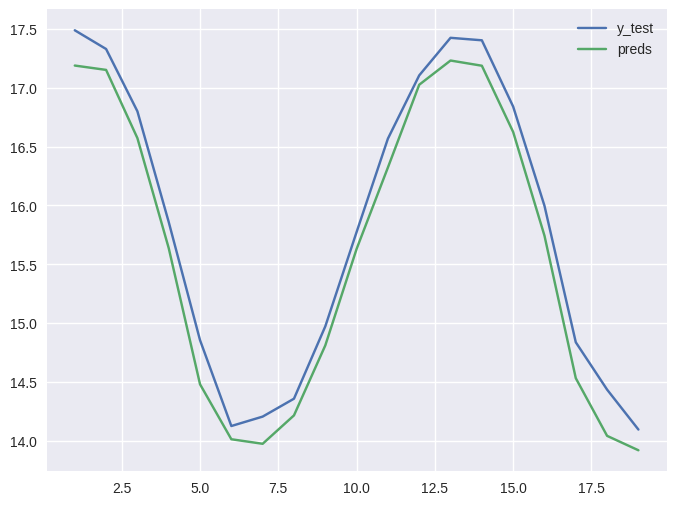

In [60]:
df_results.plot()

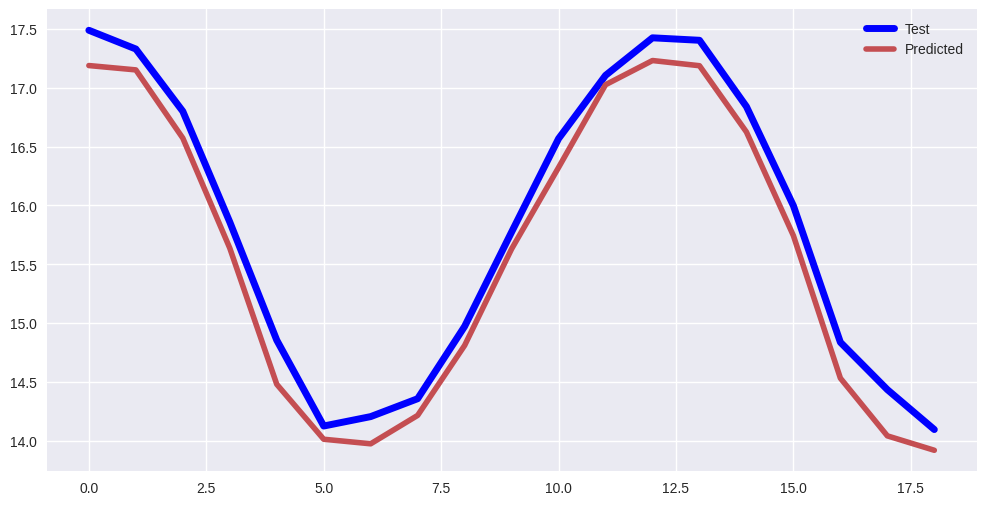

In [61]:
plt.figure(figsize=(12,6))
plt.plot(y_test_vals, 'blue', linewidth=5)
plt.plot(preds,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.show()

In [62]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [63]:
# Calculate MAPE
m = tf.keras.metrics.MeanAbsolutePercentageError()
m.update_state(y_test_vals, preds)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1.0>

In [64]:
mse = mean_squared_error(y_test_vals, preds)
mae = mean_absolute_error(y_test_vals, preds)
mape = m.result().numpy()/100  # adjust Keras output to match scikit
from sklearn.metrics import mean_absolute_percentage_error
sk_mape = mean_absolute_percentage_error(y_test_vals, preds)

In [65]:
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'SKMAPE: {sk_mape}')

MSE: 0.05443283924546458
MAE: 0.21931411703009437
MAPE: 0.013993620872497559
SKMAPE: 0.013993623512768292


**Journal entry**

In [66]:
import csv

In [67]:
with open(JOURNAL_LOG, 'w') as csvfile:
  writer = csv.writer(csvfile)
  #writer.writerow(['DateTime','Model','TargetLabel','NumFeatures','WindowSize','TestPct','NumEpochs','MSE','MAE','MAPE','SKMAPE','Columns'])
  writer.writerow([dt.today().strftime("%Y%m%d-%H%M"),MODEL_NAME,TARGET_LABEL,NUM_FEATURES,INPUT_WINDOW,TEST_RATIO,num_epochs,mse,mae,mape,sk_mape,COLS])